# Aprendizaje por refuerzo profundo - Libreta 4
*por Roberto-Esteban López-Díaz*


Obetivos de esta libreta:
- Policy Evaluation
- Policy Iteration
- Value iteration

In [ ]:
# Ejecutar una vez
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

In [ ]:
# Importar librerias
import matplotlib.pyplot as plt
import numpy as np
#from RL_Toy.envs import gridWorld
from RL_Toy.policies import gridPolicy
from RL_Toy.envs import stochasticGridWorld
from RL_Toy.base import Environment, Policy, AgentToy

## Creando un entorno para las pruebas en la libreta

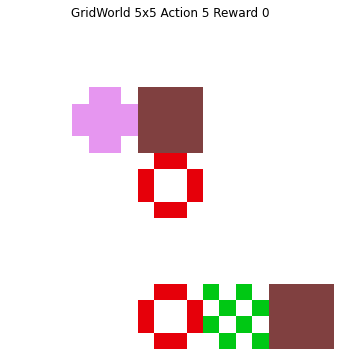

In [ ]:
env = stochasticGridWorld(5,5, (1,1),(4,3),"8C",200)
env.addObstacles((4,4),(1,2))
env.addVortex((4,2,0.5), (2,2,0.2))
obs = env.reset()
env.render()

Este entorno tiene un método especial de .transProb(), cual devuelve los posibles siguientes estados y sus probabilidades, siendo esto un acceso al modelo $s' \sim \mathcal{P}(\cdot| s, a)$

In [ ]:
env.transProb(obs, 1)

(array([0.2, 0.8], dtype=float32), [(2, 2), (0, 0)])

Con acceso al modelo, se podemos aplicar algorimos basados en modelos como los son aquellos basados en programación dinámica. 
Este ha sido uno de los motivos de generar un entorno desde cero poder aplicar de manera didactica estos algoritmos y saber que funcionan. 

In [ ]:
pi = gridPolicy(env)

In [ ]:
pi.pi

array([[2, 5, 6, 1, 5],
       [6, 5, 0, 8, 6],
       [9, 3, 1, 5, 7],
       [5, 6, 1, 8, 9],
       [1, 6, 2, 4, 0]], dtype=uint8)

In [ ]:
class AgentGrid(AgentToy):
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
        super().__init__()
    def processObs(self, obs):
        if isinstance(obs, dict):
            return obs["agent"]
        return obs

In [ ]:
agent = AgentGrid(env, pi)

In [ ]:
agent.test(n_test = 30)

([-18.0,
  -20.0,
  -21.0,
  -23.0,
  -19.0,
  -19.0,
  -22.0,
  -17.0,
  -18.0,
  -16.0,
  -22.0,
  -22.0,
  -21.0,
  -21.0,
  -17.0,
  -16.0,
  -21.0,
  -24.0,
  -16.0,
  -16.0,
  -28.0,
  -15.0,
  -16.0,
  -24.0,
  -17.0,
  -18.0,
  -15.0,
  -16.0,
  -20.0,
  -16.0],
 [4,
  6,
  7,
  9,
  5,
  5,
  8,
  3,
  4,
  2,
  8,
  8,
  7,
  7,
  3,
  2,
  7,
  10,
  2,
  2,
  14,
  1,
  2,
  10,
  3,
  4,
  1,
  2,
  6,
  2])

## Policy evaluation

Momento de escribir la función para resolver esta tarea

*Todos pseudo códigos fueron extraidos del libro de Suton Y Barto.*

Cómo se discutio en el material, este algoritmo propone la evaluación de la polícitca de manera iterativa para encontrar $\hat{v}_\pi(s)$. Un aproximado a la función de valor real de la política. La forma con la que actualiza los valores aproximados están basados en la ecuación de Bellman de la misma función  de valor 

$v_{k+1}(s) = \mathbb{E}_\pi [R_t + v_k(s') | S_t = s]$

### Pseudocódigo de Evaluación Iterativa de la Política

Input $\pi$, the policy to be evaluated
Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation
Initialize $V(s)$, for all $s\in \mathit{S^+}$, arbitrarily except that $V(terminal) = 0$

Loop:
- $\Delta \leftarrow 0$
- Loop for each $s\in \mathit{S}$:
    - $v \leftarrow V(s)$
    - $V(s) \leftarrow \Sigma_a \pi(a|s)\Sigma_{s',r}p(s',r | s, a)[r+\gamma V(s')]$
    - $\Delta \leftarrow \max(\Delta, |v-V(s)|)$

until $\Delta < \theta$

In [ ]:
def policyEvaluation(env:Environment, policy:Policy, k:int, 
                     thres:float = 0.01, gamma:float = 0.99):
    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    V = np.zeros(env.shape, dtype=np.float32)
    states = env.observationSpace
    actions = env.actionSpace
    diff = 0
    # Policy evaluation
    # Iteration as stop condition
    for i in range(k):
        # Do a copy of V_t to be V_{t - 1}
        Vpass = np.copy(V)
        # Iterate the states of the environment
        for state in states:
            # Check if the state is terminal
            if env.isTerminal(state):
                V[state] = 0
                continue # With this the next code is not not executed
            # Get the action from the policy
            action = policy.getAction(state)
            # Get the probabilities and next states corresponding to the
            # actual state and action
            E = 0
            probs, next_states = env.transProb({"agent":state}, action)
            for prob, next_state in zip(probs, next_states):
                r = env.calculateReward(next_state)
                E += prob * (r + gamma * Vpass[next_state])
            # Update the value function given pi
            V[state] = E
            diff = max(diff, Vpass[state] - E)
        # First condition
        if diff < thres:
            return V
    return V

In [ ]:
V_pi = policyEvaluation(env, pi, 1000)

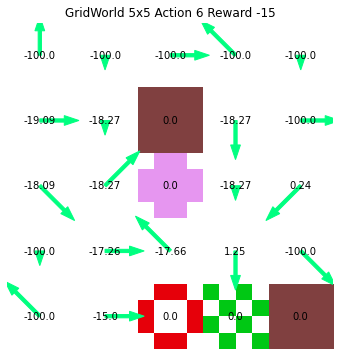

In [ ]:
env.render(values = V_pi, policy = pi)

## Mejora de la politica con Iteración de politica
1. Initialization $V(s)\in \mathbb{R} $ and $ \pi(s)\in \mathit{A}(s)$
2. Policy Evaluation.
3. Policy improvement
    - $\text{policy-stable} \leftarrow \text{true}$
    - For each $s\in \mathit(S)$:
        - $\text{old-action} \leftarrow \pi(s)$
        - $\pi(s)\leftarrow \arg \max_a \Sigma_{s',r}p(s', r | s,a)[r + \gamma V(s')] $
        - If $\text{old-action} \neq \pi(s)$,  $\text{policy-stable} \leftarrow false$

if $\text{policy-stable}$, then stop and return $V$, else return to step 2.

In [ ]:
def policyIteration(env:Environment, policy:Policy, k_eva:int, 
                    k_improvement:int, thres:float = 0.01, gamma:float = 0.99,):
    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert k_improvement > 0, \
        "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    states = env.observationSpace
    actions = env.actionSpace
    # Iteration as alternate stop condition
    for improvement in range(k_improvement):
        # Policy evaluation
        V = policyEvaluation(env, policy, k_eva, thres = thres, gamma = gamma)
        # Policy improvement
        policyStable = True
        # Iterate the states
        for state in states:
            oldAction = policy.getAction(state)
            maxAction = None
            ### MISSING PART

            ### How to calculate the best action given the new evaluation?
            ### ----------------------------------------------------
            if maxAction != oldAction:
                policyStable = False
        # Stop condition check
        if policyStable == True:
            print("Policy stable afer {} iterations".format(improvement))
            return V
    print("Stopped after all the iterations")
    return V

## Value Iteration
### Pseudocode
Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation.

Initialize $V(s)$, for all $a\in \mathit{S^+}$, arbitrarily except that $V(terminal)=0$

Loop:
- $\Delta \leftarrow 0$
- Loop for each $s\in \mathit{S}$:
    - $v \leftarrow V(s)$
    - $V(S) \leftarrow \max_a \Sigma_{s',r}p(s', r | s,a)[r + \gamma V(s')]$
    - $\Delta \leftarrow \max(\Delta, |v-V(s)|)$

until $\Delta < 0$

Output a deterministic policy, $\pi \approx \pi_*$, such that

$\pi(s) = \arg \max_a \Sigma_{s',r} p(s',r| s, a)[r+\gamma V(s')]$

In [ ]:
def valueIteration(env:Environment, k:int, thres:float = 0.01, gamma:float = 0.99):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    actions = env.actionSpace
    states = env.observationSpace
    V = np.zeros(env.shape, dtype=np.float32)
    diff = 0
    # Start the iterations
    for iteration in range(k):
        # Do a copy of V_t as is now V_{t-1}
        Vpass = np.copy(V)
        # For each state of all available
        for state in states:
            maxSum = - np.inf
            maxAction = None
            stateDict = {"agent": state}
            # If the state is terminal assign V(s) = 0
            if env.isTerminal(stateDict):
                V[state] = 0
                continue # With this the next code is not not executed
            ### MISSING PART
            V = Vpass(state)
            for action in actions:
                # Get the probabilities and next states corresponding to the
                # actual state and action
                probs, nextStates = env.transProb(state, action)
                E = 0
                for p, s in zip(probs, nextStates):
                    r = env.calculateReward({"agent":s})
                    E += p * (r + gamma * Vpass[s])
                if E > maxSum:
                    maxSum = E
                    maxAction = action
            ### Same as before, calculate the max value for the value function?
            ### --------------
            V[state] = maxSum
            diff = max(diff, Vpass[state] - maxSum)
        # First stop condition
        if diff < thres:
            return V
    return V